In [1]:
!pip install transformers

     |████████████████████████████████| 2.3MB 6.8MB/s 
     |████████████████████████████████| 901kB 44.9MB/s 
     |████████████████████████████████| 3.3MB 51.9MB/s 


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from transformers import (
    BertTokenizer,
    TFBertForSequenceClassification
)

tf.random.set_seed(42)

In [3]:
data_source = "https://github.com/clairett/pytorch-sentiment-classification/raw/master/data/SST2/train.tsv"
df = pd.read_csv(data_source, delimiter="\t", header=None)
df.rename(columns={0: "reviews", 1: "label"}, inplace=True)


smaller_batch = df[:2000]

label_series = smaller_batch["label"]

model_name = "bert-base-uncased"
tokenizer = BertTokenizer.from_pretrained(model_name)

In [4]:
tokenized = smaller_batch["reviews"].apply(
    (lambda review: tokenizer.encode(review, add_special_tokens=True))
)


max_len = np.max([len(tokenized_review) for tokenized_review in tokenized])
min_len = np.min([len(tokenized_review) for tokenized_review in tokenized])
avg_len = np.mean([len(tokenized_review) for tokenized_review in tokenized])
print("The length of the longest review:", max_len)
print("The length of the shortest review:", min_len)
print("The average length of all the reviews:", avg_len)

shortest_reviews = [
    tokenized_review for tokenized_review in tokenized if len(tokenized_review) == 3
]
print(shortest_reviews, "\n")
for review in shortest_reviews:
    print(tokenizer.convert_ids_to_tokens(review, skip_special_tokens=False))

padded_ids = np.array([i + [0] * (max_len - len(i)) for i in tokenized.values])
attention_mask = np.where(padded_ids != 0, 1, 0)


label = label_series.to_numpy()
label = to_categorical(label, num_classes=2)

The length of the longest review: 59
The length of the shortest review: 3
The average length of all the reviews: 23.823
[[101, 10166, 102], [101, 2053, 102], [101, 9202, 102], [101, 6659, 102]] 

['[CLS]', 'wow', '[SEP]']
['[CLS]', 'no', '[SEP]']
['[CLS]', 'horrible', '[SEP]']
['[CLS]', 'terrible', '[SEP]']


In [5]:
model = TFBertForSequenceClassification.from_pretrained(model_name)
model.summary()

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model: "tf_bert_for_sequence_classification"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bert (TFBertMainLayer)       multiple                  109482240 
_________________________________________________________________
dropout_37 (Dropout)         multiple                  0         
_________________________________________________________________
classifier (Dense)           multiple                  1538      
Total params: 109,483,778
Trainable params: 109,483,778
Non-trainable params: 0
_________________________________________________________________


In [6]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=5e-5),
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=["accuracy"],
)

inputs = {"input_ids":padded_ids, "attention_mask":attention_mask}
history = model.fit(inputs, label, batch_size=32, epochs=10, validation_split=0.2)

Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autog

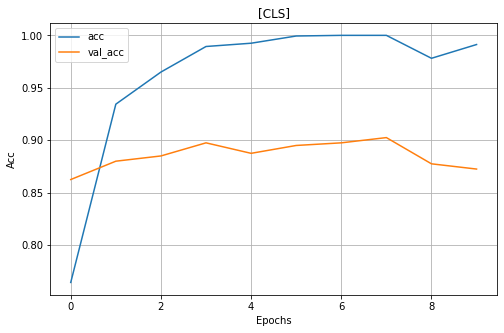

In [7]:
# %%
plt.figure(figsize=(8, 5))
plt.plot(history.history["accuracy"], label="acc")
plt.plot(history.history["val_accuracy"], label="val_acc")
plt.grid(True)
plt.xlabel("Epochs")
plt.ylabel("Acc")
plt.title("[CLS]")
plt.legend()
plt.show()